In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt


In [2]:
# Get the USPS dataset
batch_size = 128

transform = transforms.Compose(
    [transforms.ToTensor()])

dataset = torchvision.datasets.EuroSAT(root='./data', download=False, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                            shuffle=False, num_workers=2)

classes = ('AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake')

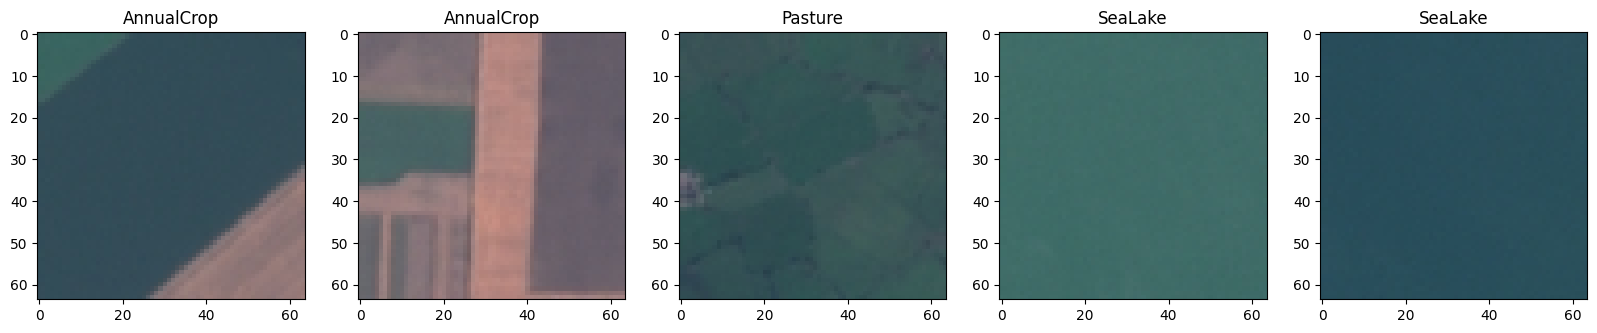

In [3]:
def show_image(dataset, index):
    image, label = dataset[index]
    image = image.permute(1, 2, 0)
    plt.imshow(image)
    plt.title(classes[label])

plt.figure(figsize=(20, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    show_image(train_dataset, i * 100)
plt.show()

In [4]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.flattend_size = 32 * 4 * 4
        self.conv1 = nn.Conv2d(3, 16, 5, padding=2)
        self.pool = nn.MaxPool2d(4, 4)
        self.conv2 = nn.Conv2d(16, 32, 7, padding=3)
        self.fc1 = nn.Linear(self.flattend_size, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 10)
        self.batch_norm = nn.BatchNorm2d(16)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.dropout = nn.Dropout(0.2)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.batch_norm(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.batch_norm2(x)
        x = x.view(-1, self.flattend_size)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
def train(net, trainloader, optimizer, loss):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss_val = loss(outputs, labels)
        loss_val.backward()
        optimizer.step()
        running_loss += loss_val.item()
    return running_loss / len(trainloader)

def test(net, testloader, loss):
    net.eval()
    running_loss = 0.0
    correct      = 0
    total        = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = net(inputs)
            loss_val = loss(outputs, labels)
            running_loss += loss_val.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

def training_loop(epochs, net, trainloader, testloader, optimizer, loss):
    accuracies = []
    losses = []

    for epoch in range(epochs):
        train_loss = train(net, trainloader, optimizer, loss)
        accuracy = test(net, testloader, loss)
        accuracies.append(accuracy)
        losses.append(train_loss)
        print(f"Epoch {epoch} - Train Loss: {train_loss} Accuracy: {accuracy}")

    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.plot(accuracies)
    plt.title('Accuracy')
    plt.xlabel('Epoch [#]')
    plt.ylabel('Accuracy [%]')
    plt.subplot(122)
    plt.plot(losses)
    plt.title('Loss')
    plt.xlabel('Epoch [#]')
    plt.ylabel('Loss [NLL]')
    plt.show()

    return accuracies, losses

In [7]:
net = CustomCNN()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
loss = nn.CrossEntropyLoss()
net.to(device)

CustomCNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
  (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

MIOpen(HIP): Warning [SQLiteBase] Missing system database file: gfx1030_20.kdb Performance may degrade. Please follow instructions to install: https://github.com/ROCmSoftwarePlatform/MIOpen#installing-miopen-kernels-package


Epoch 0 - Train Loss: 1.7736746665288712 Accuracy: 0.6105555555555555
Epoch 1 - Train Loss: 1.147736108161994 Accuracy: 0.7231481481481481
Epoch 2 - Train Loss: 0.9122719052275257 Accuracy: 0.7494444444444445
Epoch 3 - Train Loss: 0.7927210486146825 Accuracy: 0.785
Epoch 4 - Train Loss: 0.7103950187299378 Accuracy: 0.7946296296296296
Epoch 5 - Train Loss: 0.6659140879585899 Accuracy: 0.8046296296296296
Epoch 6 - Train Loss: 0.6201379558391119 Accuracy: 0.8061111111111111
Epoch 7 - Train Loss: 0.5921431892722316 Accuracy: 0.8211111111111111
Epoch 8 - Train Loss: 0.5600660660210446 Accuracy: 0.8335185185185185
Epoch 9 - Train Loss: 0.546669120795628 Accuracy: 0.8088888888888889
Epoch 10 - Train Loss: 0.5205141625108098 Accuracy: 0.8192592592592592
Epoch 11 - Train Loss: 0.49457329546911477 Accuracy: 0.8375925925925926
Epoch 12 - Train Loss: 0.47348635083824925 Accuracy: 0.8488888888888889
Epoch 13 - Train Loss: 0.466000845270044 Accuracy: 0.8238888888888889
Epoch 14 - Train Loss: 0.44756

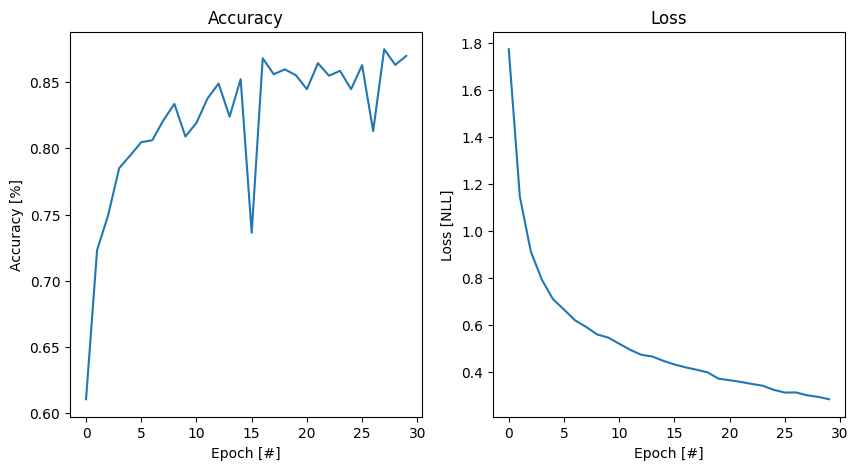

Best accuracy: 0.8748148148148148


In [8]:
EPOCHS = 30

accuracies_custom, losses_custom = training_loop(EPOCHS, net, trainloader, testloader, optimizer, loss)
print(f"Best accuracy: {max(accuracies_custom)}")

Training last resnet layer


/home/alexander/Dokumente/Studium/INFM-2/ki-lab-ss23/.env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/alexander/Dokumente/Studium/INFM-2/ki-lab-ss23/.env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 - Train Loss: 0.9263782425392308 Accuracy: 0.827037037037037
Epoch 1 - Train Loss: 0.5325309965737473 Accuracy: 0.847037037037037
Epoch 2 - Train Loss: 0.4681670496449668 Accuracy: 0.8496296296296296
Epoch 3 - Train Loss: 0.43997907620915294 Accuracy: 0.8579629629629629
Epoch 4 - Train Loss: 0.4136806631229333 Accuracy: 0.8601851851851852
Epoch 5 - Train Loss: 0.4019189898431654 Accuracy: 0.8637037037037038
Epoch 6 - Train Loss: 0.3918693971175414 Accuracy: 0.8614814814814815
Epoch 7 - Train Loss: 0.3865744636432659 Accuracy: 0.8618518518518519
Epoch 8 - Train Loss: 0.3838652812341261 Accuracy: 0.8651851851851852
Epoch 9 - Train Loss: 0.37261125886228663 Accuracy: 0.8612962962962963
Epoch 10 - Train Loss: 0.36672375646568617 Accuracy: 0.8661111111111112
Epoch 11 - Train Loss: 0.3687056071130482 Accuracy: 0.8562962962962963
Epoch 12 - Train Loss: 0.36616520301477445 Accuracy: 0.8633333333333333
Epoch 13 - Train Loss: 0.3611324701965208 Accuracy: 0.8625925925925926
Epoch 14 - Tra

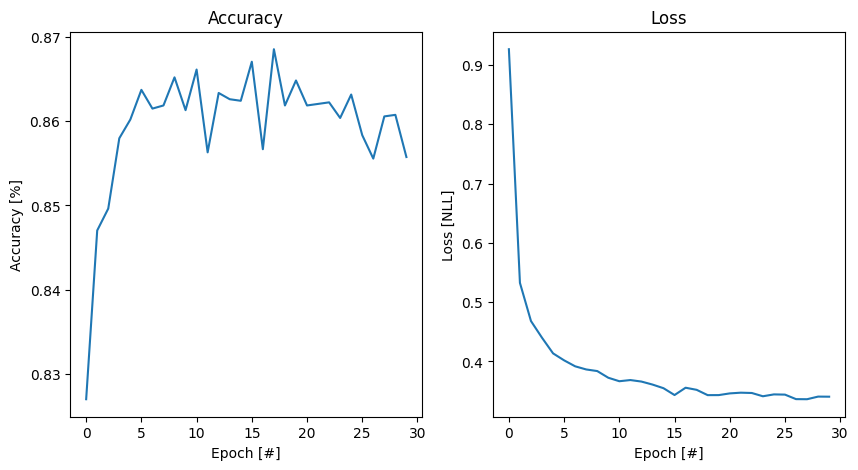

Best accuracy: 0.8685185185185185


In [10]:
resnet_fc = torchvision.models.resnet18(weights='IMAGENET1K_V1')
resnet_fc.fc = nn.Linear(512, 10)

# Freeze all layers except the last one
for name, param in resnet_fc.named_parameters():
    if not name.startswith('fc'):
        param.requires_grad = False

resnet_fc.to(device)

# Train the last layer
optimizer = optim.Adam(resnet_fc.fc.parameters(), lr=1e-3)
loss = nn.CrossEntropyLoss()
resnet_fc.to(device)

print("Training last resnet layer")

EPOCHS = 30
accuracies_resnet_fc, losses_resnet_fc = training_loop(EPOCHS, resnet_fc, trainloader, testloader, optimizer, loss)

print(f"Best accuracy: {max(accuracies_resnet_fc)}")

In [13]:
resnet_finetuned    = torchvision.models.resnet18(weights='IMAGENET1K_V1')
resnet_finetuned.fc = nn.Linear(512, 10)

resnet_finetuned.to(device)

# Train the last layer
optimizer = optim.Adam(resnet_finetuned.fc.parameters(), lr=1e-4)
loss = nn.CrossEntropyLoss()
resnet_finetuned.to(device)

print("Fine tuning resnet")

EPOCHS = 30
accuracies_resnet_ft, losses_resnet_ft = training_loop(EPOCHS, resnet_finetuned, trainloader, testloader, optimizer, loss)

print(f"Best accuracy: {max(accuracies_resnet_ft)}")

Fine tuning resnet
Epoch 0 - Train Loss: 1.9503675212521525 Accuracy: 0.5877777777777777
Epoch 1 - Train Loss: 1.3020628916441337 Accuracy: 0.7190740740740741
Epoch 2 - Train Loss: 1.0117031804908663 Accuracy: 0.7659259259259259
Epoch 3 - Train Loss: 0.8567587221867939 Accuracy: 0.7853703703703704
Epoch 4 - Train Loss: 0.760754029426349 Accuracy: 0.8007407407407408
Epoch 5 - Train Loss: 0.7035901620543215 Accuracy: 0.81
Epoch 6 - Train Loss: 0.6531202391054504 Accuracy: 0.8161111111111111
Epoch 7 - Train Loss: 0.6195041196938802 Accuracy: 0.8242592592592592
Epoch 8 - Train Loss: 0.5940243099215468 Accuracy: 0.8288888888888889
Epoch 9 - Train Loss: 0.5707854887790228 Accuracy: 0.8322222222222222
Epoch 10 - Train Loss: 0.5478979735332128 Accuracy: 0.8364814814814815
Epoch 11 - Train Loss: 0.5345388506291181 Accuracy: 0.8355555555555556
Epoch 12 - Train Loss: 0.5224684699047246 Accuracy: 0.8366666666666667
Epoch 13 - Train Loss: 0.5140043417730275 Accuracy: 0.8392592592592593
Epoch 14 - T

KeyboardInterrupt: 